# Sentiment Analysis

In [191]:
import string

import numpy as np
import scipy
import pandas as pd
import re
import matplotlib.pyplot as plt

import html

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## Load Data

In [192]:
data = pd.read_json('venv/data/presidential_speeches.json') # load data
data.sort_values(by=['date'], inplace=True) # sort by data
data.reset_index(drop=True, inplace=True) # reset index

## Preprocessing the Data

In [193]:
# sort presidents to their parties
president_list = []
for i in range(len(data['president'].unique())):
    president_list.append(data['president'].unique()[i])
parties_list= ['Federalist', 'Democratic-Republican', 'National Republican', 'Democratic', 'Whig', 'Republican', 'Democratic (Union)']
sort_party = [0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 3, 4, 4, 5, 3, 3, 6, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 5, 5, 3, 5, 3, 5, 3, 5, 3]
party = []
for i in range(len(sort_party)):
    party.append(parties_list[sort_party[i]])
data['party'] = pd.Series(dtype='string')
for i in range(len(president_list)):
    data['party'][data['president'] == president_list[i]] = party[i]
# assign each speech its respective era
data['era'] = pd.Series(dtype='string')
era_list = ['Early Republic', 'Jacksonian Democracy', 'Sectional Conflict', 'Gilded Age', 'Progressive Era', 'Depression and World Conflict', 'Social Change and Soviet Relations', 'Globalization']
for i in range(len(data)):
    if data['date'][i] < pd.Timestamp('1829-01-01T12'):
        data['era'][i] =  era_list[0]
    if pd.Timestamp('1829-01-01T12') <= data['date'][i] < pd.Timestamp('1853-01-01T12'):
        data['era'][i] = era_list[1]
    elif pd.Timestamp('1853-01-01T12') <= data['date'][i] < pd.Timestamp('1881-01-01T12'):
        data['era'][i] = era_list[2]
    elif pd.Timestamp('1881-01-01T12') <= data['date'][i] < pd.Timestamp('1897-01-01T12'):
        data['era'][i] = era_list[3]
    elif pd.Timestamp('1897-01-01T12') <= data['date'][i] < pd.Timestamp('1921-01-01T12'):
        data['era'][i] = era_list[4]
    elif pd.Timestamp('1921-01-01T12') <= data['date'][i] < pd.Timestamp('1961-01-01T12'):
        data['era'][i] = era_list[5]
    elif pd.Timestamp('1961-01-01T12') <= data['date'][i] < pd.Timestamp('1989-01-01T12'):
        data['era'][i] = era_list[6]
    elif pd.Timestamp('1989-01-01T12') <= data['date'][i]:
        data['era'][i] = era_list[7]

In [195]:
data['transcript'].replace(to_replace='(Applause.)', regex=True, value='', inplace=True)
data['transcript'].replace(to_replace='(Laughter.)', regex=True, value='', inplace=True)
for i in range(len(data)):
    data['transcript'][i] = data['transcript'][i].replace('\'', '')

C:\Users\Enno\AppData\Local\Temp/ipykernel_25980/192661657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['transcript'][i] = data['transcript'][i].replace('\'', '')


The Following section is code adapted from Srikanth Shenoy and can be found under https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8 (accessed on 02/10/2023)

In [196]:
import string
import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from textblob import TextBlob
from unidecode import unidecode

In [197]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [198]:

class NltkPreprocessingSteps:
  def __init__(self, X):
    self.X = X

    self.sw_nltk = stopwords.words('english')
    # remove some noise
    new_stopwords = ['<*>', 'q', 'yeah', 'guy', 'okay', 'ahead', 'mr', 'st', 'really', 'please', 'yes', 'sir', 'youn']
    self.sw_nltk.extend(new_stopwords)
    self.sw_nltk.remove('not')

    self.pos_tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

    # '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~' 32 punctuations in python
    # we dont want to replace . first time around
    self.remove_punctuations = string.punctuation.replace('.','')

  def remove_html_tags(self):
    self.X = self.X.apply(
            lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return self

  def replace_diacritics(self):
    self.X = self.X.apply(
            lambda x: unidecode(x, errors="preserve"))
    return self

  def to_lower(self):
    self.X = np.apply_along_axis(lambda x: x.lower(), self.X)
    return self

  def expand_contractions(self):
    self.X = self.X.apply(
            lambda x: " ".join([contractions.fix(expanded_word) 
                        for expanded_word in x.split()]))
    return self

  def remove_numbers(self):
    self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
    return self

  def replace_dots_with_spaces(self):
    self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
    return self

  def remove_punctuations_except_periods(self):
    self.X = self.X.apply(
                 lambda x: re.sub('[%s]' %
                  re.escape(self.remove_punctuations), '' , x))
    return self

  def remove_all_punctuations(self):
    self.X = self.X.apply(lambda x: re.sub('[%s]' %
                          re.escape(string.punctuation), '' , x))
    return self

  def remove_double_spaces(self):
    self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
    return self

  def fix_typos(self):
    self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
    return self

  def remove_stopwords(self):
    # remove stop words from token list in each column
    self.X = self.X.apply(
            lambda x: " ".join([ word for word in x.split() 
                     if word not in self.sw_nltk]) )
    return self

  def get_processed_text(self):
    return self.X

In [199]:
txt_preproc = NltkPreprocessingSteps(data['transcript'])
processed_text = \
    txt_preproc \
    .remove_html_tags()\
    .replace_diacritics()\
    .expand_contractions()\
    .remove_double_spaces()\
    .get_processed_text()

In [200]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
data['vader'] =pd.Series(dtype='object')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [201]:
for i in range(len(processed_text)):
    processed_text[i] = nltk.sent_tokenize(processed_text[i])

In [202]:
vader_model = SentimentIntensityAnalyzer()
for i in range(len(processed_text)):
    score_list = []
    for j in range(len(processed_text[i])):
        score_list.append(vader_model.polarity_scores(processed_text[i][j])['compound'])
    data['vader'][i] = score_list

C:\Users\Enno\AppData\Local\Temp/ipykernel_25980/2386764690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vader'][i] = score_list


## Sentiment Analysis

In [203]:
data['sentiment'] =pd.Series(dtype='object')
data['total_sentiment'] = pd.Series(dtype='object')

In [204]:
# assign sentiment based on polarity score, if > 0.001 == positive, if < -0.001 == negative, else neutral 
for i in range(len(data)):
    sentiment_list = []
    pos = 0
    neu = 0
    neg = 0
    for j in range(len(data['vader'][i])):
        if data['vader'][i][j] > 0.001:
            sentiment_list.append('pos')
            pos += 1
        elif -0.001 <= data['vader'][i][j] <= 0.001:
            sentiment_list.append('neu')
            neu += 1
        elif data['vader'][i][j] < -0.001:
            sentiment_list.append('neg')
            neg += 1
    data['sentiment'][i] = sentiment_list
    data['total_sentiment'][i] = [pos, neu, neg]

C:\Users\Enno\AppData\Local\Temp/ipykernel_25980/3952271288.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][i] = sentiment_list
C:\Users\Enno\AppData\Local\Temp/ipykernel_25980/3952271288.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_sentiment'][i] = [pos, neu, neg]


## Make Graphs

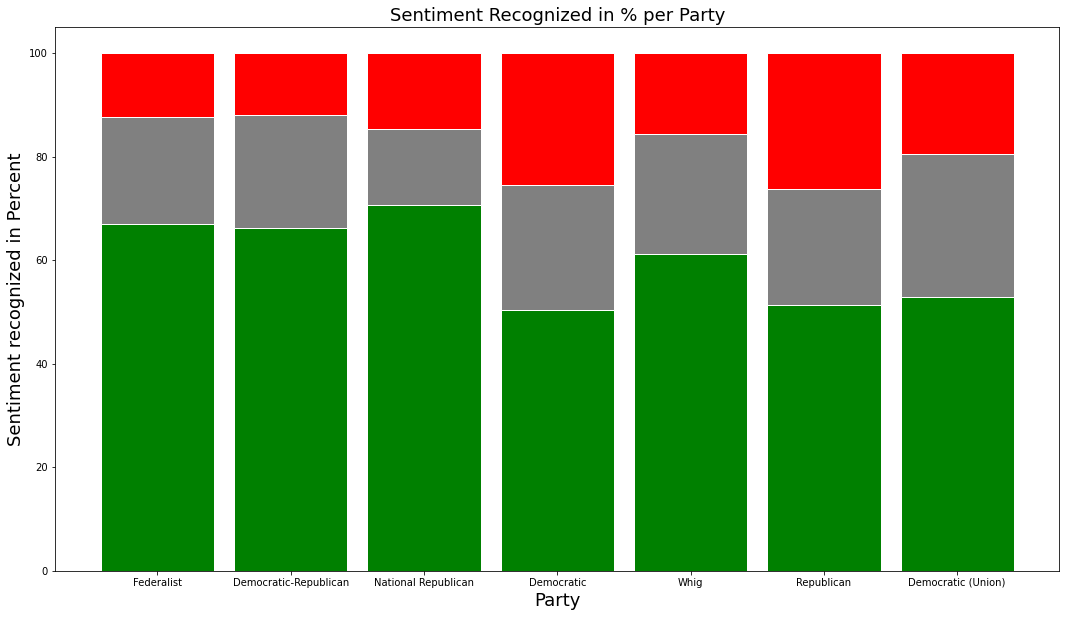

In [218]:
sort_by_era = []
sort_by_party = []
for i in range(len(parties_list)):
    f = data.loc[data['party'] == parties_list[i]]['total_sentiment']
    f.reset_index(drop=True, inplace=True)
    sort_by_party.append(f)
total_sentiment = []
for i in range(len(sort_by_party)):
    pos = 0
    neu = 0
    neg = 0
    for j in range(len(sort_by_party[i])):
        pos += sort_by_party[i][j][0]
        neu += sort_by_party[i][j][1]
        neg += sort_by_party[i][j][2]
    total_sentiment.append([parties_list[i], pos, neg, neu])
df = pd.DataFrame(total_sentiment, columns=['party','pos', 'neu', 'neg'])
df_total = df["pos"] + df["neu"] + df["neg"] 
df_rel = df[df.columns[1:]].div(df_total, 0)*100

r = [0,1,2,3,4,5,6]

barWidth = 0.85
plt.figure(figsize=(18, 10))
plt.bar(r, df_rel['pos'], color='green', edgecolor='white', width=barWidth)
plt.bar(r, df_rel['neu'], bottom=df_rel['pos'], color='grey', edgecolor='white', width=barWidth)
plt.bar(r, df_rel['neg'], bottom=[i+j for i,j in zip(df_rel['pos'], df_rel['neu'])], color='red', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, parties_list)
plt.xlabel("Party", fontsize='18')
plt.ylabel("Sentiment recognized in Percent", fontsize='18')
plt.title('Sentiment Recognized in % per Party', fontsize=18)
plt.savefig('SentimentParty', dpi=100)

         pos        neu        neg
0  67.063922  20.455038  12.481040
1  60.538117  25.076937  14.384947
2  54.785479  26.567657  18.646865
3  60.879036  21.271143  17.849821
4  57.469794  23.617626  18.912580
5  51.736093  25.085403  23.178504
6  49.305728  22.983128  27.711143
7  46.376812  21.778863  31.844326


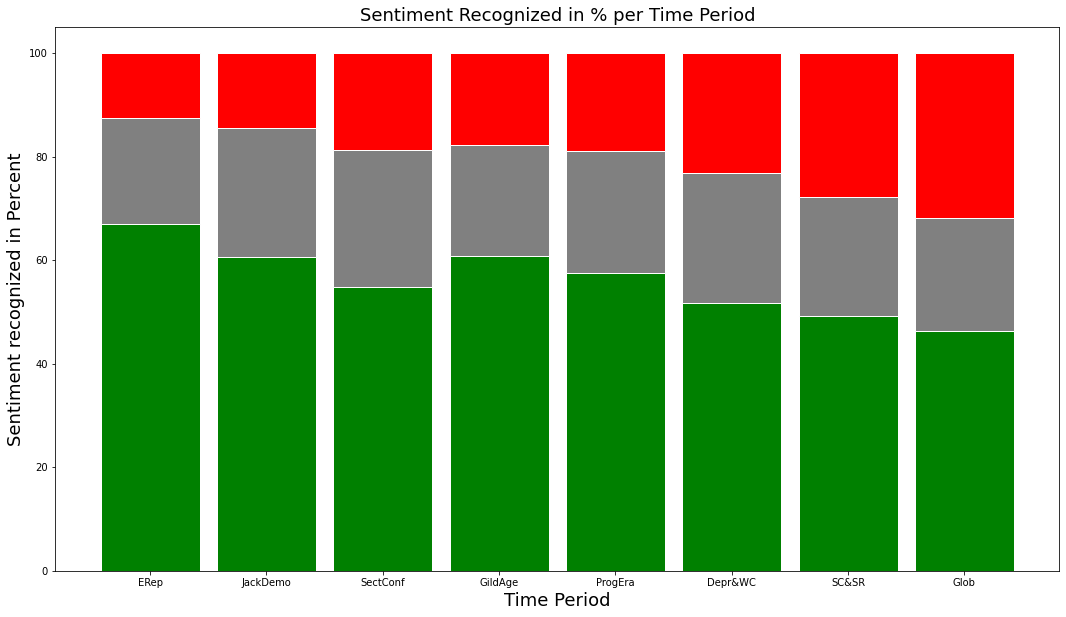

In [219]:
sort_by_era = []
for i in range(len(era_list)):
    f = data.loc[data['era'] == era_list[i]]['total_sentiment']
    f.reset_index(drop=True, inplace=True)
    sort_by_era.append(f)
total_sentiment = []
for i in range(len(sort_by_era)):
    pos = 0
    neu = 0
    neg = 0
    for j in range(len(sort_by_era[i])):
        pos += sort_by_era[i][j][0]
        neu += sort_by_era[i][j][1]
        neg += sort_by_era[i][j][2]
    total_sentiment.append([era_list[i], pos, neg, neu])
df = pd.DataFrame(total_sentiment, columns=['era','pos', 'neu', 'neg'])
df_total = df["pos"] + df["neu"] + df["neg"] 
df_rel = df[df.columns[1:]].div(df_total, 0)*100

r = [0,1,2,3,4,5,6,7]

barWidth = 0.85
plt.figure(figsize=(18, 10))
plt.bar(r, df_rel['pos'], color='green', edgecolor='white', width=barWidth)
plt.bar(r, df_rel['neu'], bottom=df_rel['pos'], color='grey', edgecolor='white', width=barWidth)
plt.bar(r, df_rel['neg'], bottom=[i+j for i,j in zip(df_rel['pos'], df_rel['neu'])], color='red', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, ['ERep', 'JackDemo', 'SectConf', 'GildAge', 'ProgEra', 'Depr&WC', 'SC&SR', 'Glob'])
plt.xlabel("Time Period", fontsize='18')
plt.ylabel("Sentiment recognized in Percent", fontsize='18')
plt.title('Sentiment Recognized in % per Time Period', fontsize=18)
plt.savefig('SentimentEra', dpi=100)
print(df_rel)
